# Cumulos Abiertos: Laboratorio 3: Calculo de Ganancia y Ruido de Lectura de una CCD
Juan David Galan Vargas - 202111470

In [1]:
from glob import glob
from astropy.io import fits
#from astropy.io import trim_image

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pandas as pd

# statistics
from astropy.stats import biweight_location, biweight_scale, sigma_clipped_stats
from scipy.stats import median_abs_deviation

# configuration
np.set_printoptions(linewidth=120) # para que se vea
plt.rcParams["image.cmap"] = "magma" # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.rcParams["image.origin"] = "lower"

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

c:\Users\juang\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\juang\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# Seccion 1: Alcyone

In [2]:
glob("*")

['bias y flats no overscan.png',
 'ccd.ipynb',
 'ciencia menos bias.png',
 'data',
 'diferencias.png',
 'FLATS',
 'flats menos bias.png',
 'Graficas informe 3',
 'histograma flats normalizados.png',
 'Imagenes Reducidos',
 'intensidades flats.png',
 'Laboratorio 2 Juan Galan 202111470.ipynb',
 'Laboratorio 3 Juan Galan 202111470.ipynb',
 'procesadas.png',
 'raws bias y flats.png',
 'raws science.png',
 'Raws.png',
 'Toma de datos 11-03']

In [3]:
files_uniandes = glob("data/uniandes/*.FIT")
files_uniandes

['data/uniandes\\Alcyone.fit',
 'data/uniandes\\b1.fit',
 'data/uniandes\\b2.fit',
 'data/uniandes\\b3.fit',
 'data/uniandes\\b4.fit',
 'data/uniandes\\b5.fit',
 'data/uniandes\\b6.fit',
 'data/uniandes\\b7.fit',
 'data/uniandes\\b8.fit',
 'data/uniandes\\b9.fit',
 'data/uniandes\\d1.fit',
 'data/uniandes\\d2.fit',
 'data/uniandes\\d3.fit',
 'data/uniandes\\d4.fit',
 'data/uniandes\\d5.fit',
 'data/uniandes\\d6.fit',
 'data/uniandes\\d7.fit',
 'data/uniandes\\d8.fit',
 'data/uniandes\\d9.fit',
 'data/uniandes\\Flat_1.fit',
 'data/uniandes\\Flat_2.fit',
 'data/uniandes\\Flat_3.fit']

In [4]:
for file in files_uniandes:
    print(fits.info(file))

Filename: data/uniandes\Alcyone.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/uniandes\b1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/uniandes\b2.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/uniandes\b3.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/uniandes\b4.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/uniandes\b5.fit
No.    Name      Ver    Type      Cards   Dimensi

In [5]:
images = [fits.getdata(f) for f in files_uniandes]

In [6]:
headers = [fits.getheader(f) for f in files_uniandes]
headers

[SIMPLE  =                    T /                                                
 BITPIX  =                   16 /                                                
 NAXIS   =                    2 /                                                
 NAXIS1  =                  765 /                                                
 NAXIS2  =                  510 /                                                
 OBJECT  = 'Alcyone '                                                            
 TELESCOP= 'Meade LX200'                                                         
 INSTRUME= 'SBIG ST-402'                                                         
 OBSERVER= 'Maria Gracia Batista'                                                
 DATE-OBS= '2024-02-10T01:39:58.000' / GMT START OF EXPOSURE [WIN]               
 BZERO   = +3.276800000000E+004 /                                                
 BSCALE  = +1.000000000000E+000 /                                                
 EXPTIME = +5.00

In [7]:
headers = [fits.getheader(f)["EXPTIME"] for f in files_uniandes]
headers

[0.5,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.1,
 0.1,
 0.1]

Text(0.5, 1.0, 'Histograma de los Flats')

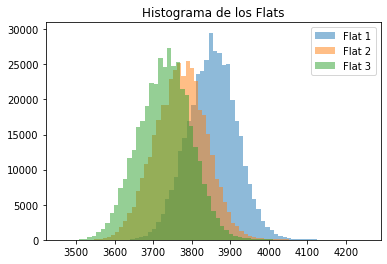

In [8]:
plt.hist(images[-3].ravel(), bins=60, alpha=0.5,label="Flat 1")
plt.hist(images[-2].ravel(), bins=60,alpha=0.5,label="Flat 2")
plt.hist(images[-1].ravel(), bins=60,alpha=0.5,label="Flat 3")
plt.legend()
plt.title("Histograma de los Flats")

In [9]:
flat1=images[-3].ravel()
np.median(flat1)

3854.0

In [10]:
flat2=images[-2].ravel()
np.median(flat2)

3773.0

In [11]:
flat3=images[-1].ravel()
np.median(flat3)

3732.0

In [12]:
flats=[flat1,flat2,flat3]

In [13]:
for i in range(3):
    median= np.median(flats[i])
    var=np.var(flats[i])
    mean=flats[i].mean()
    sigma=median_abs_deviation(flats[i], scale="normal")
    print("Mediana/var")
    print(median/var)
    print("Media/var")
    print(mean/var)
    print("Mediana/sigma**2")
    print(median/(sigma**2))
    mean1, median1, sted1 =sigma_clipped_stats(flats[i])
    print("Mediana_c/sted_c")
    print(median1/(sted1)**2)
    print("media_c/std_c")
    print(mean1/(sted1**2))
    G_median=[median/var,median/(sigma**2),median1/(sted1)**2]
    print("Ganancia Mediana")
    print(sum(G_median)/len(G_median))
    G_mean=[mean/var,mean/(sigma**2),mean1/(sted1)**2]
    print("Ganancia Media")
    print(sum(G_median)/len(G_median))

Mediana/var
0.9631687742791328
Media/var
0.9630527831538023
Mediana/sigma**2
0.9482558002719488
Mediana_c/sted_c
1.0085056047688392
media_c/std_c
1.0082773487241297
Ganancia Mediana
0.9733100597733069
Ganancia Media
0.9733100597733069
Mediana/var
0.8518114484227187
Media/var
0.8514497527692302
Mediana/sigma**2
0.8476420367556287
Mediana_c/sted_c
0.8891965717043406
media_c/std_c
0.8887244336643488
Ganancia Mediana
0.8628833522942294
Ganancia Media
0.8628833522942294
Mediana/var
0.8105330107887482
Media/var
0.8101936527882985
Mediana/sigma**2
0.8023736914377342
Mediana_c/sted_c
0.841258254455133
media_c/std_c
0.8408222673680025
Ganancia Mediana
0.8180549855605385
Ganancia Media
0.8180549855605385


In [14]:
from itertools import combinations

In [15]:
Bias_mean=[]
Flats_mean=[]
for i in range(9):
    mean= images[i+1].ravel().mean()
    Bias_mean.append(mean)
for i in range(3):
    mean=flats[i].ravel().mean()
    Flats_mean.append(mean)

In [16]:
Bias=[]
for i in range(9):
    b= images[i+1]
    Bias.append(b)
Flats=[images[-3],images[-2],images[-1]]


In [17]:
Bias_combinations = list(combinations(Bias, 2))
Flats_combinations = list(combinations(Flats, 2))

# Combine letter and number combinations
result = [(b1, b2, f1, f2) 
          for (b1, b2) in Bias_combinations 
          for (f1, f2) in Flats_combinations]
gains=[]
noise=[]
# Print the result
for combination in result:
    Diff_flats=combination[2].astype('int64')-combination[3].astype('int64')
    Diff_Bias=combination[0].astype('int64')-combination[1].astype('int64')
    sigma_flats=(np.std(Diff_flats))
    sigma_bias=(np.std(Diff_Bias))
    #sigma_flats=median_abs_deviation(Diff_flats.ravel())
    #sigma_bias=median_abs_deviation(Diff_Bias.ravel())
    #a,b,sigma_flats=sigma_clipped_stats(Diff_flats)
    #c,d,sigma_bias=sigma_clipped_stats(Diff_Bias)
    flat_mean1=combination[2].mean()
    flat_mean2=combination[3].mean()
    bias_mean1=combination[0].mean()
    bias_mean2=combination[1].mean()
    Gain=((flat_mean1+flat_mean2)-(bias_mean1+bias_mean2))/((sigma_flats**2)-(sigma_bias**2))
    gains.append(Gain)
    noi=(Gain*sigma_bias)/np.sqrt(2)
    noise.append(noi)
print(np.mean(gains))
print(np.mean(noise))

1.433402230957285
21.47031348303281


Text(0.5, 0, 'e/ADU')

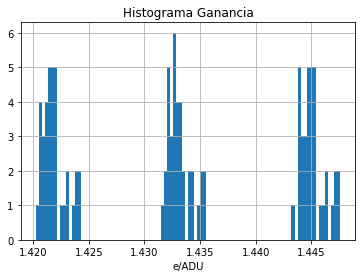

In [18]:
plt.hist(gains, bins=100)
plt.grid(True)
plt.title("Histograma Ganancia")
plt.xlabel("e/ADU")

Text(0.5, 0, 'e Rms')

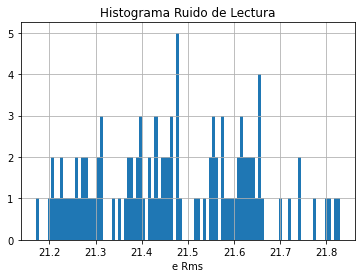

In [19]:
plt.hist(noise, bins=100)
plt.grid(True)
plt.title("Histograma Ruido de Lectura")
plt.xlabel("e Rms")

# Seccion 2: Flats y Bias tomados

In [20]:
BIAS = glob("data/bias fit/*.FIT")
BIAS

['data/bias fit\\bias1.fit',
 'data/bias fit\\bias10.fit',
 'data/bias fit\\bias100.fit',
 'data/bias fit\\bias11.fit',
 'data/bias fit\\bias12.fit',
 'data/bias fit\\bias13.fit',
 'data/bias fit\\bias14.fit',
 'data/bias fit\\bias15.fit',
 'data/bias fit\\bias16.fit',
 'data/bias fit\\bias17.fit',
 'data/bias fit\\bias18.fit',
 'data/bias fit\\bias19.fit',
 'data/bias fit\\bias2.fit',
 'data/bias fit\\bias20.fit',
 'data/bias fit\\bias21.fit',
 'data/bias fit\\bias22.fit',
 'data/bias fit\\bias23.fit',
 'data/bias fit\\bias24.fit',
 'data/bias fit\\bias25.fit',
 'data/bias fit\\bias26.fit',
 'data/bias fit\\bias27.fit',
 'data/bias fit\\bias28.fit',
 'data/bias fit\\bias29.fit',
 'data/bias fit\\bias3.fit',
 'data/bias fit\\bias30.fit',
 'data/bias fit\\bias31.fit',
 'data/bias fit\\bias32.fit',
 'data/bias fit\\bias33.fit',
 'data/bias fit\\bias34.fit',
 'data/bias fit\\bias35.fit',
 'data/bias fit\\bias36.fit',
 'data/bias fit\\bias37.fit',
 'data/bias fit\\bias38.fit',
 'data/bias 

In [21]:
for file in BIAS:
    print(fits.info(file))

Filename: data/bias fit\bias1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/bias fit\bias10.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/bias fit\bias100.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/bias fit\bias11.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/bias fit\bias12.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   (765, 510)   int16 (rescales to uint16)   
None
Filename: data/bias fit\bias13.fit
No.    Name      Ver    Type  

In [22]:
bias_header = [fits.getheader(f)["EXPOSURE"] for f in BIAS]
bias_header

[0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04]

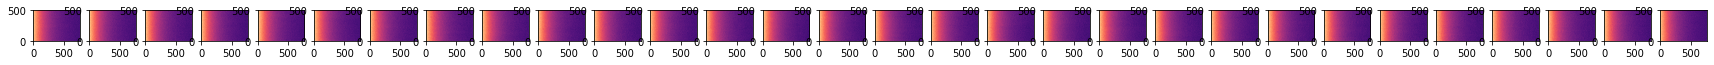

In [23]:
bias = [fits.getdata(f) for f in BIAS]
fig,ax = plt.subplots(ncols=30,figsize=(30,30))
for i in range(30):
    plt.sca(ax[i])
    quantile_imshow(bias[i])
    
    #plt.colorbar()

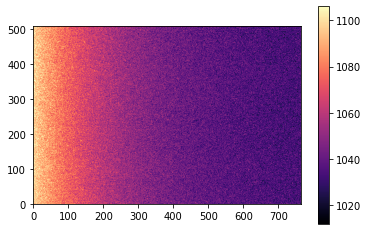

In [24]:
quantile_imshow(bias[90])    
plt.colorbar()

In [25]:
promedio_bias=[]
for i in range(100):
    pro=(bias[i]).mean()
    promedio_bias.append(pro)
print(promedio_bias)
print(np.mean(promedio_bias))
print(np.median(promedio_bias))

[1053.8610918877355, 1053.7737741894143, 1050.354730231962, 1053.5797283096244, 1054.2131180315264, 1053.463352556709, 1053.2582006920416, 1053.1909855183903, 1053.4926361655773, 1053.1538331410995, 1052.8749019607842, 1053.5076483403818, 1054.3608868383956, 1052.8942714340637, 1052.6841086761501, 1053.1512879661668, 1053.417078046905, 1052.6290452390106, 1052.7734896834552, 1052.5893938228887, 1053.1948455722159, 1052.7907163911316, 1052.841630142253, 1053.9573471741637, 1052.8417172882225, 1052.5305549147763, 1052.0676329616815, 1052.3730129437397, 1052.6681942842497, 1052.4515494040754, 1052.9352889914135, 1052.5667743175702, 1052.4758503139817, 1052.3194745610663, 1054.0185569652697, 1052.0851185441497, 1052.3048058439063, 1052.5943252595155, 1052.10738177624, 1052.223209022171, 1052.1695476098937, 1052.0061258490325, 1052.104910931693, 1051.84830449827, 1052.4170447263873, 1054.0981314878893, 1052.0327028066129, 1051.0754530308855, 1052.2993899782134, 1051.843967704729, 1051.42752

In [26]:
for i in range(100):
    bias[i] = bias[i].astype(np.float64)

[[1101.84 1101.29 1098.11 ... 1035.14 1034.81 1035.28]
 [1100.1  1101.69 1097.49 ... 1033.79 1034.86 1031.89]
 [1100.49 1099.23 1097.87 ... 1033.58 1035.54 1035.11]
 ...
 [1101.12 1101.59 1097.23 ... 1035.19 1034.92 1033.24]
 [1100.3  1102.15 1096.52 ... 1034.1  1034.02 1033.84]
 [1097.81 1098.97 1096.94 ... 1037.19 1035.87 1034.25]]


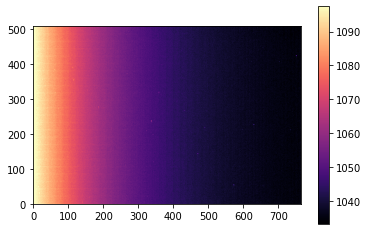

In [27]:
El_Bias=sum(bias)/100
print(El_Bias)
quantile_imshow(El_Bias)    
plt.colorbar()

In [28]:
FLATS = glob("FLATS/*.FIT")
FLATS

['FLATS\\FLAT0041.fit',
 'FLATS\\FLAT0042.fit',
 'FLATS\\FLAT0043.fit',
 'FLATS\\FLAT0044.fit',
 'FLATS\\FLAT0061.fit',
 'FLATS\\FLAT0062.fit',
 'FLATS\\FLAT0063.fit',
 'FLATS\\FLAT0064.fit',
 'FLATS\\FLAT0091.fit',
 'FLATS\\FLAT0092.fit',
 'FLATS\\FLAT0093.fit',
 'FLATS\\FLAT0094.fit',
 'FLATS\\FLAT0111.fit',
 'FLATS\\FLAT0112.fit',
 'FLATS\\FLAT0113.fit',
 'FLATS\\FLAT0114.fit',
 'FLATS\\FLAT0131.fit',
 'FLATS\\FLAT0132.fit',
 'FLATS\\FLAT0133.fit',
 'FLATS\\FLAT0134.fit',
 'FLATS\\FLAT0161.fit',
 'FLATS\\FLAT0162.fit',
 'FLATS\\FLAT0163.fit',
 'FLATS\\FLAT0164.fit',
 'FLATS\\FLAT0181.fit',
 'FLATS\\FLAT0182.fit',
 'FLATS\\FLAT0183.fit',
 'FLATS\\FLAT0184.fit',
 'FLATS\\FLAT0201.fit',
 'FLATS\\FLAT0202.fit',
 'FLATS\\FLAT0203.fit',
 'FLATS\\FLAT0204.fit',
 'FLATS\\FLAT0231.fit',
 'FLATS\\FLAT0232.fit',
 'FLATS\\FLAT0233.fit',
 'FLATS\\FLAT0234.fit',
 'FLATS\\FLAT0251.fit',
 'FLATS\\FLAT0252.fit',
 'FLATS\\FLAT0253.fit',
 'FLATS\\FLAT0254.fit']

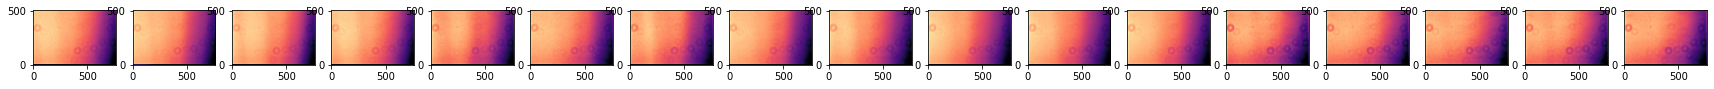

In [29]:
Flats_lab = [fits.getdata(f) for f in FLATS]
fig,ax = plt.subplots(ncols=17,figsize=(30,7))
for i in range(17):
    plt.sca(ax[i])
    quantile_imshow(Flats_lab[i])
    #plt.colorbar()

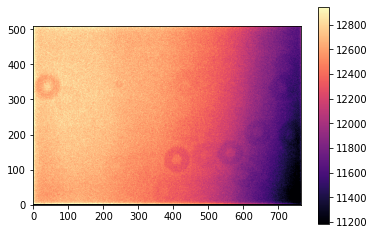

In [30]:
quantile_imshow(Flats_lab[0]) 
plt.colorbar()

In [31]:
Flats_header = [fits.getheader(f)["EXPOSURE"] for f in FLATS]
Flats_header

[0.04,
 0.04,
 0.04,
 0.04,
 0.06,
 0.06,
 0.06,
 0.06,
 0.09,
 0.09,
 0.09,
 0.09,
 0.11,
 0.11,
 0.11,
 0.11,
 0.13,
 0.13,
 0.13,
 0.13,
 0.16,
 0.16,
 0.16,
 0.16,
 0.18,
 0.18,
 0.18,
 0.18,
 0.2,
 0.2,
 0.2,
 0.2,
 0.23,
 0.23,
 0.23,
 0.23,
 0.25,
 0.25,
 0.25,
 0.25]

In [32]:
len(Flats_lab)

40

In [33]:
for i in range(40):
    Flats_lab[i]=Flats_lab[i]-El_Bias

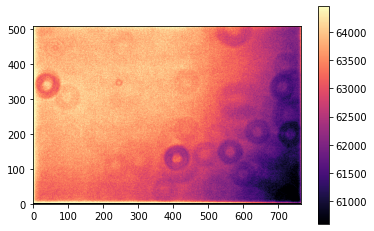

In [34]:
quantile_imshow(Flats_lab[39]) 
plt.colorbar()

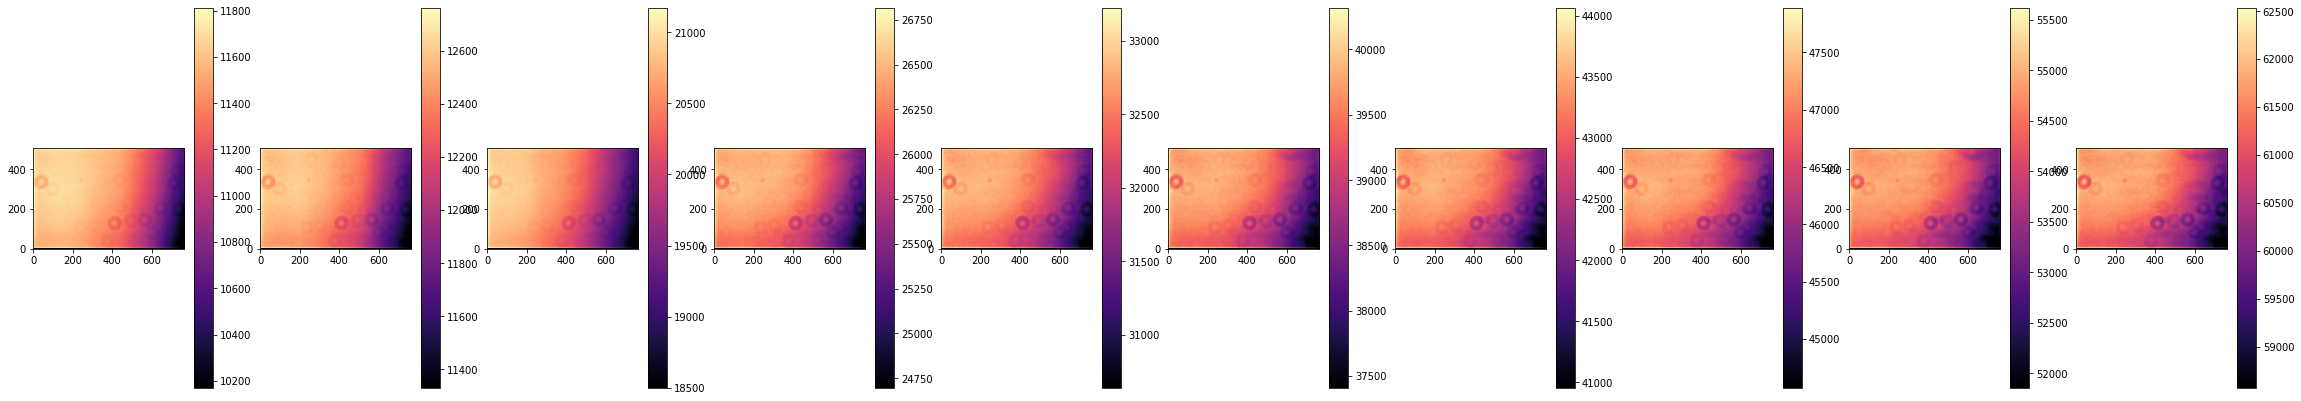

In [35]:
Flats_ExpTime = [Flats_lab[i:i+4] for i in range(0, len(Flats_lab), 4)]
Sumas=[]
for i in range(10):
    suma=sum(Flats_ExpTime[i])/len(Flats_ExpTime[i])
    Sumas.append(suma)
fig,ax = plt.subplots(ncols=10,figsize=(40,7))
for i in range(10):  
    plt.sca(ax[i])
    quantile_imshow(Sumas[i])
    plt.colorbar()  

In [36]:
len(Sumas)

10

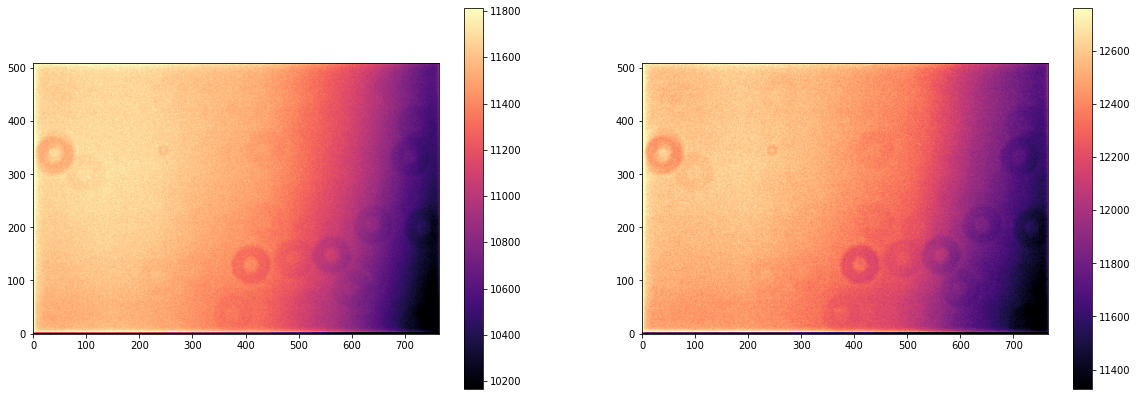

In [37]:
fig,ax = plt.subplots(ncols=2,figsize=(20,7))
for i in range(2):  
    plt.sca(ax[i])
    quantile_imshow(Sumas[i])
    plt.colorbar()

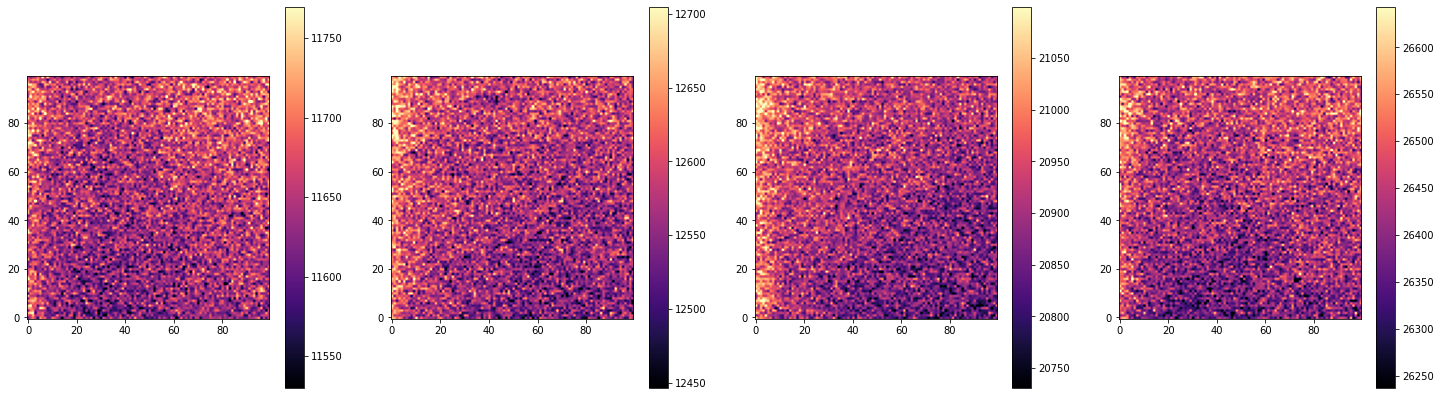

In [38]:
fig,ax = plt.subplots(ncols=4,figsize=(25,7))
recortadas=[]
for i in range(10):
    trimmed = (Sumas[i][150:250, 10:110])
    recortadas.append(trimmed)
for i in range(4):  
    plt.sca(ax[i])
    quantile_imshow(recortadas[i])
    plt.colorbar()

In [39]:
Mean_Levels=[]
for i in range(10):
    pro=(recortadas[i]).mean()
    Mean_Levels.append(pro)
print(Mean_Levels)

[11648.881332, 12573.708807, 20905.531557, 26433.684132, 32764.841981999998, 39736.086532, 43416.630782, 47199.103657, 54820.33205699999, 61691.71210699999]


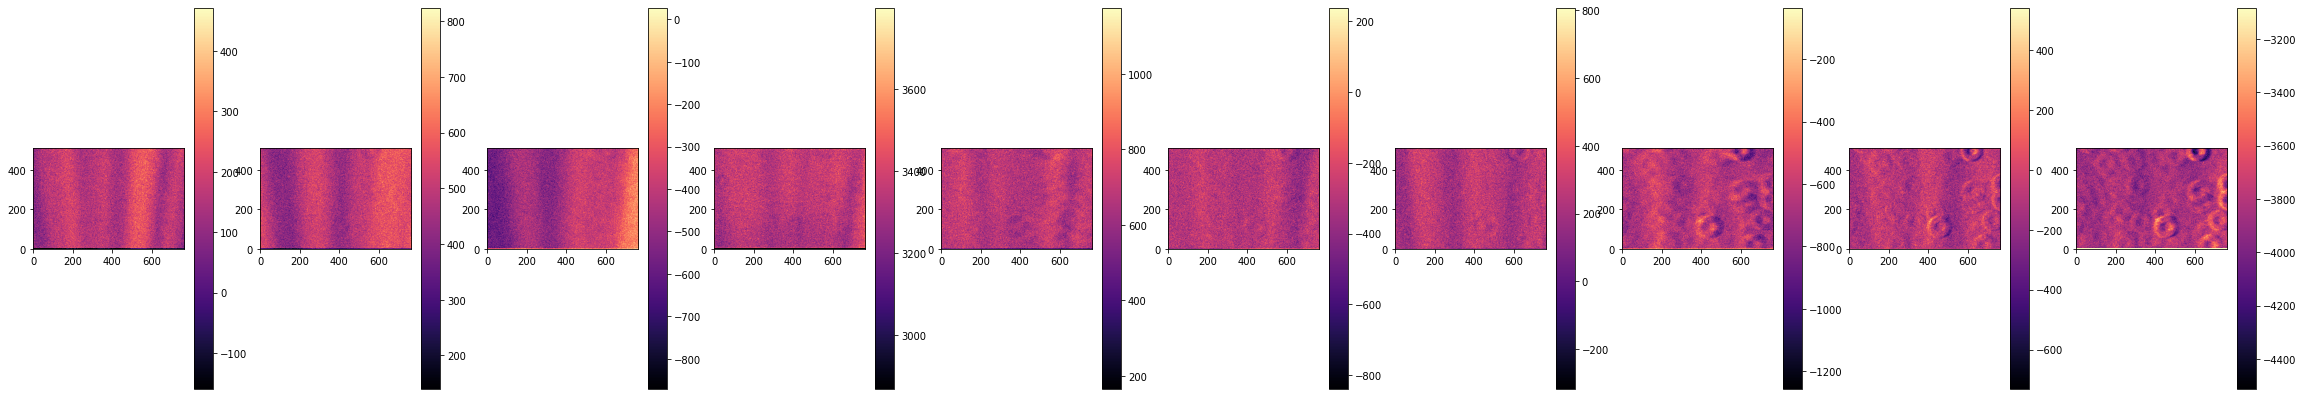

In [40]:
Restas=[]
for i in range(10):
    resta=(Flats_ExpTime[i][0]-Flats_ExpTime[i][1])
    Restas.append(resta)
fig,ax = plt.subplots(ncols=10,figsize=(40,7))
for i in range(10):  
    plt.sca(ax[i])
    quantile_imshow(Restas[i])
    plt.colorbar()  

In [41]:
All_differences = []

# Iterate over each element of Flats_ExpTime
for element in Flats_ExpTime:
    differences = []  # List to store differences for the current element
    # Iterate over each pair of elements within the current element
    for i in range(len(element)):
        for j in range(i + 1, len(element)):
            # Calculate the difference between the ith and jth elements
            resta = element[i] - element[j]
            # Append the difference to the list of differences for the current element
            differences.append(resta)
    # Append the list of differences for the current element to the list of all differences
    All_differences.append(differences)
len(All_differences)

10

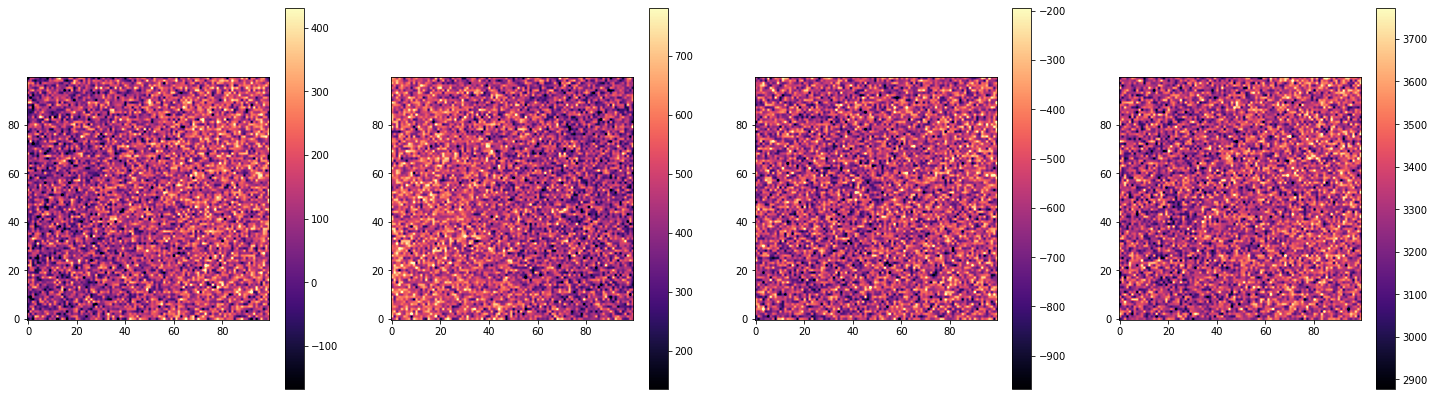

In [42]:
fig,ax = plt.subplots(ncols=4,figsize=(25,7))
recortadas2=[]
for i in range(10):
    trimmed2 = (Restas[i][150:250, 10:110])
    recortadas2.append(trimmed2)
for i in range(4):  
    plt.sca(ax[i])
    quantile_imshow(recortadas2[i])
    plt.colorbar()

In [43]:
recortadas3=[]
for i in range(10):
    recor3=[]
    for j in range(6):
        trimmed2 = (All_differences[i][j][150:250, 10:110])
        recor3.append(trimmed2)
    recortadas3.append(recor3)
len(recortadas3[0])

6

In [44]:
Var=[]
for i in range(10):
    pro2=(recortadas2[i]).std()
    pro2=(pro2**2)/2
    Var.append(pro2)
print(Var)

[8462.333249955002, 9513.838398875001, 14051.033529195003, 18507.93013112, 22304.93295995501, 26738.938900879995, 29054.405425795, 32356.278492194997, 37375.17249099499, 39394.10351671999]


In [45]:
Var2=[]
for i in range(10):
    v2=[]
    for j in range(6):
        pro2=(recortadas3[i][j]).std()
        pro2=(pro2**2)/2
        v2.append(pro2)
    Var2.append(v2)
print(Var2)

[[8462.333249955002, 9332.740446755, 8111.547855119999, 8341.64302142, 8532.385554795, 9575.385630555], [9513.838398875001, 9669.932914875002, 8913.197903754999, 8833.3630955, 8463.119454079999, 8680.00322798], [14051.033529195003, 13981.67451182, 14416.467873919999, 13970.564846874999, 14274.062668874998, 14469.086179499996], [18507.93013112, 19592.303855500002, 18323.9094875, 17960.51149582, 17080.53385262, 17742.651898], [22304.93295995501, 22043.726058220014, 22563.061034355003, 22164.384551195002, 22877.03896062, 21877.369138755006], [26738.938900879995, 26902.225513555004, 27259.369478955, 26588.600009995, 26969.084853875, 27590.054127020005], [29054.405425795, 28660.21463632, 30070.606793875, 28987.651740355006, 28951.001892319997, 29560.982879795007], [32356.278492194997, 31265.319138, 31409.48769551999, 32391.764174395, 31644.257875555002, 31886.31519832], [37375.17249099499, 37746.216785595, 35924.627582195004, 36933.91309118, 36878.06395838001, 37267.773882000016], [39394.10

In [46]:
from scipy.stats import linregress

0.9980813638983677
1.5606042567920655


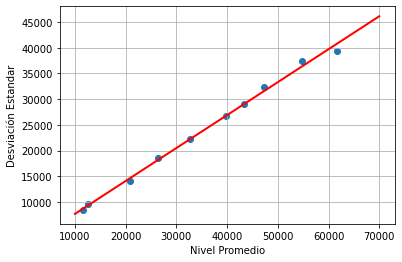

In [47]:
plt.scatter(Mean_Levels,Var)
slope, intercept, r_value, p_value, std_err = linregress(Mean_Levels, Var)
x=np.linspace(10000,70000,10)
y=  intercept + slope * x
plt.plot(x, y, color='red', linewidth=2, label='Linear Regression')
plt.grid(True)
plt.xlabel("Nivel Promedio")
plt.ylabel("Desviación Estandar")
print(r_value)
print(1/slope)

In [48]:
# List of elements by their position
elements_by_position = [[] for _ in range(len(Var2[0]))]  # Create an empty list for each position
for sublist in Var2:
    for i, element in enumerate(sublist):
        elements_by_position[i].append(element)

# List of mean values of each of the 10 lists
mean_values = [sum(sublist) / len(sublist) for sublist in Var2]

print("List of elements by their position:")
print(elements_by_position)
print("\nList of mean values of each of the 10 lists:")
print(mean_values)


List of elements by their position:
[[8462.333249955002, 9513.838398875001, 14051.033529195003, 18507.93013112, 22304.93295995501, 26738.938900879995, 29054.405425795, 32356.278492194997, 37375.17249099499, 39394.10351671999], [9332.740446755, 9669.932914875002, 13981.67451182, 19592.303855500002, 22043.726058220014, 26902.225513555004, 28660.21463632, 31265.319138, 37746.216785595, 41230.969837954995], [8111.547855119999, 8913.197903754999, 14416.467873919999, 18323.9094875, 22563.061034355003, 27259.369478955, 30070.606793875, 31409.48769551999, 35924.627582195004, 41504.982178080005], [8341.64302142, 8833.3630955, 13970.564846874999, 17960.51149582, 22164.384551195002, 26588.600009995, 28987.651740355006, 32391.764174395, 36933.91309118, 39789.31165919501], [8532.385554795, 8463.119454079999, 14274.062668874998, 17080.53385262, 22877.03896062, 26969.084853875, 28951.001892319997, 31644.257875555002, 36878.06395838001, 41090.47405128], [9575.385630555, 8680.00322798, 14469.0861794999

In [49]:
dict = {
    0: "1-2",
    1: "2-3",
    2: "3-4",
    3: "1-3",
    4: "2-4",
    5: "1-4"}

1.5606042567920655
1.552752417293078
1.5210926130013431
1.5378018546811039
1.51049287752792
1.5370110630554965


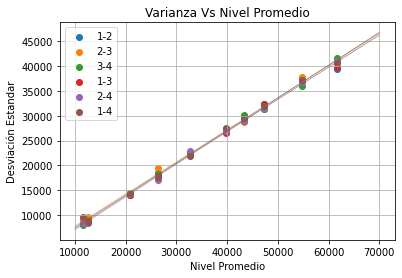

In [50]:
#Y=mean_values
Ganancias=[]
for i in range(6):
    Y=elements_by_position[i]
    plt.scatter(Mean_Levels,Y,label=dict[i])
    slope, intercept, r_value, p_value, std_err = linregress(Mean_Levels, Y)
    x=np.linspace(10000,70000,10)
    y=  intercept + slope * x
    plt.plot(x, y, linewidth=0.3)
    plt.grid(True)
    plt.title("Varianza Vs Nivel Promedio")
    plt.xlabel("Nivel Promedio")
    plt.ylabel("Desviación Estandar")
    plt.legend()
    #print(r_value)
    print(1/slope)
    Ganancias.append(1/slope)

In [51]:
Promedio_Ganancia=sum(Ganancias)/len(Ganancias)
print(Promedio_Ganancia)

1.5366258470585012


In [52]:
# Initialize lists to store standard deviations and differences
std_deviations = []
differences = []

# Iterate through all combinations of two arrays
for arr1, arr2 in combinations(bias, 2):
    # Subtract arrays and calculate standard deviation
    diff = arr1 - arr2
    std_deviation = np.std(diff)
    
    # Append results to lists
    differences.append(diff)
    std_deviations.append(std_deviation)

# Calculate the mean of standard deviations
mean_std_deviation = np.mean(std_deviations)

print("Mean standard deviation of differences:", mean_std_deviation)


Mean standard deviation of differences: 17.29315581803736


In [53]:
Ruido=[]
for i in range(len(Ganancias)):
    ruido=(Ganancias[i]*mean_std_deviation)/np.sqrt(2)
    print(ruido)
    Ruido.append(ruido)
print("--")
print(sum(Ruido)/len(Ruido))


19.083237002557972
18.98722386315181
18.600084365021967
18.80440677265358
18.470469657562724
18.794736887450185
--
18.79002642473304
